# GIN実装 - 工夫3版

## 変更点:
- GCNConvからGINConvへの変更
- 2層GIN構成（中間次元64）
- 各GINConvにMLP [Linear→ReLU→Linear→BatchNorm]
- Dropout(0.5)による正則化
- 理論的に最強の表現力（WL-test同等）

詳細は `変更点説明.md` を参照してください。

元論文：Graph Attention Networks
Petar Veličković, Guillem Cucurull, Arantxa Casanova, Adriana Romero, Pietro Liò, Yoshua Bengio
ICLR 2018

https://arxiv.org/abs/1609.02907
参考にしたコード：https://github.com/Diego999/pyGAT

全体の流れ

0.   事前にcora.contentとcora.citesをダウンロードして/content/drive/My Drive/Colab Notebooks/に置いてください．
1.   ライブラリのインストール
2.   汎用関数の定義
3.   GATモデル定義 (NN実装がわかる人はここの参照のみで十分)
4.   グラフデータ読み込み
5.   学習準備
6.   モデル学
7.   テスト精度検証
8.   結果の描画


# ライブラリのインストール

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time
import numpy as np
import scipy.sparse as sparse
import random as random
import os
import sys

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 汎用関数の定義

In [9]:
#乱数の固定化

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [10]:
def load_data():
    print("Loading Cora dataset...")
    raw_nodes_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.content', dtype="str")
    print(raw_nodes_data)
    raw_node_ids = raw_nodes_data[:, 0].astype('int32')  # 各行の一列目に格納されてるノードIDを抽出
    #print(raw_node_ids)
    raw_node_labels = raw_nodes_data[:, -1]# 各行の最終列に格納されてるラベルを抽出．このラベルが予測ターゲット
    #print(raw_node_labels)

    unique = list(set(raw_node_labels))
    #print(unique)
    labels_enumerated = np.array([unique.index(label) for label in raw_node_labels])
    #print(labels_enumerated)
    node_features = sparse.csr_matrix(raw_nodes_data[:, 1:-1], dtype="float32")
    #print(node_features)

    ids_ordered = {raw_id: order for order, raw_id in enumerate(raw_node_ids)} #実際のノードIDを0から節点数-1に対応付け
    #print(ids_ordered)
    raw_edges_data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/cora.cites', dtype="int32")
    #print(raw_edges_data)
    edges = np.array(list(map(ids_ordered.get, raw_edges_data.flatten())), dtype='int32').reshape(raw_edges_data.shape) # 実際のノードIDを変換. reshapeでデータ構造を元の枝ファイルと同様に変更．
    #print(edges)

    # GCN用：隣接行列の計算（正規化は不要、GCNConvが自動で行う）
    adj = sparse.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                            shape=(labels_enumerated.shape[0], labels_enumerated.shape[0]),
                            dtype=np.float32)
    adj = adj + adj.T.multiply(adj.T > adj) #隣接行列を対称に変更 (つまり，無向グラフに変換)
    print(f"エッジ数: {adj.nnz}")

    features = torch.FloatTensor(node_features.toarray())
    labels = torch.LongTensor(labels_enumerated)

    # GCN用：エッジインデックス形式に変換（PyTorch Geometric標準）
    # 自己ループを追加して、エッジインデックス形式で返す
    adj_with_self_loops = adj + sparse.eye(adj.shape[0])
    coo = adj_with_self_loops.tocoo()
    edge_index = torch.LongTensor(np.vstack((coo.row, coo.col)))

    print(f"ノード数: {features.shape[0]}")
    print(f"特徴量次元: {features.shape[1]}")
    print(f"エッジインデックス形状: {edge_index.shape}")

    return features, labels, edge_index, edges

In [11]:
def visualize_embedding_tSNE(labels, y_pred, num_classes):

    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray"}

    node_labels = labels.cpu().numpy()
    out_features = y_pred.detach().cpu().numpy()
    t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(out_features)

    plt.figure()
    for class_id in range(num_classes):
        plt.scatter(t_sne_embeddings[node_labels == class_id, 0],
                    t_sne_embeddings[node_labels == class_id, 1], s=20,
                    color=cora_label_to_color_map[class_id],
                    edgecolors='black', linewidths=0.15)

    plt.axis("off")
    plt.title("Visualizing t-SNE")
    plt.show()

# GINモデル定義

In [12]:
class GINConv(nn.Module):
    """Graph Isomorphism Network Convolution Layer"""
    def __init__(self, nn_module, eps=0.0, train_eps=False):
        super(GINConv, self).__init__()
        self.nn = nn_module
        self.initial_eps = eps
        if train_eps:
            self.eps = nn.Parameter(torch.Tensor([eps]))
        else:
            self.register_buffer('eps', torch.Tensor([eps]))

    def forward(self, x, edge_index):
        # エッジインデックスから隣接ノードの特徴量を集約
        row, col = edge_index
        
        # 隣接ノードの特徴量を集約（sum aggregation）
        out = torch.zeros_like(x)
        out.index_add_(0, row, x[col])
        
        # GINの更新式: h^(l+1) = MLP((1 + ε) * h^(l) + Σ h_j^(l))
        out = (1 + self.eps) * x + out
        
        return self.nn(out)

def create_mlp(input_dim, hidden_dim, output_dim):
    """MLPを作成する関数: Linear → ReLU → Linear → BatchNorm"""
    return nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, output_dim),
        nn.BatchNorm1d(output_dim)
    )

class GIN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GIN, self).__init__()

        # 第1層のMLP: [Linear(1433→64) → ReLU → Linear(64→64) → BatchNorm]
        mlp1 = create_mlp(in_channels, hidden_channels, hidden_channels)
        self.conv1 = GINConv(mlp1)

        # 第2層のMLP: [Linear(64→64) → ReLU → Linear(64→7) → BatchNorm]
        mlp2 = create_mlp(hidden_channels, hidden_channels, out_channels)
        self.conv2 = GINConv(mlp2)

        # Dropout率
        self.dropout = dropout

        print(f"GINモデル構成:")
        print(f"  入力次元: {in_channels}")
        print(f"  隠れ層次元: {hidden_channels}")
        print(f"  出力次元: {out_channels}")
        print(f"  Dropout率: {dropout}")
        print(f"  MLP構成: [Linear→ReLU→Linear→BatchNorm] × 2層")
        print(f"  理論的表現力: WL-test同等")

    def forward(self, x, edge_index):
        # 第1層: GINConv(MLP1) + Dropout
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # 第2層: GINConv(MLP2) + LogSoftmax
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    def get_mlp_info(self):
        """MLPの詳細情報を取得"""
        mlp1_params = sum(p.numel() for p in self.conv1.nn.parameters())
        mlp2_params = sum(p.numel() for p in self.conv2.nn.parameters())
        return {
            'mlp1_parameters': mlp1_params,
            'mlp2_parameters': mlp2_params,
            'total_mlp_parameters': mlp1_params + mlp2_params
        }

    def __repr__(self):
        mlp_info = self.get_mlp_info()
        return (f'{self.__class__.__name__}(\n'
                f'  conv1: GINConv(MLP1) - {mlp_info["mlp1_parameters"]} params\n'
                f'  conv2: GINConv(MLP2) - {mlp_info["mlp2_parameters"]} params\n'
                f'  dropout: {self.dropout}\n'
                f'  total_parameters: {mlp_info["total_mlp_parameters"]}\n'
                f')')


In [13]:
# GINモデルは上記で既に定義済み
# 以下は参考用のパラメータ数計算関数

def count_parameters(model):
    """モデルのパラメータ数を計算"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_model_info(model):
    """モデルの詳細情報を表示"""
    print(f"モデル: {model.__class__.__name__}")
    print(f"総パラメータ数: {count_parameters(model):,}")

    # GINの場合、MLP詳細も表示
    if hasattr(model, 'get_mlp_info'):
        mlp_info = model.get_mlp_info()
        print(f"MLP1パラメータ数: {mlp_info['mlp1_parameters']:,}")
        print(f"MLP2パラメータ数: {mlp_info['mlp2_parameters']:,}")

    print(f"モデル構造:")
    print(model)

def print_mlp_details(model):
    """MLPの詳細構造を表示"""
    if hasattr(model, 'conv1') and hasattr(model.conv1, 'nn'):
        print("第1層MLP構成:")
        for i, layer in enumerate(model.conv1.nn):
            print(f"  [{i}] {layer}")

        print("\n第2層MLP構成:")
        for i, layer in enumerate(model.conv2.nn):
            print(f"  [{i}] {layer}")

# グラフデータ読み込み

グラフ読み込み

In [14]:
features, labels, edge_index, edges = load_data()

Loading Cora dataset...
[['31336' '0' '0' ... '0' '0' 'Neural_Networks']
 ['1061127' '0' '0' ... '0' '0' 'Rule_Learning']
 ['1106406' '0' '0' ... '0' '0' 'Reinforcement_Learning']
 ...
 ['1128978' '0' '0' ... '0' '0' 'Genetic_Algorithms']
 ['117328' '0' '0' ... '0' '0' 'Case_Based']
 ['24043' '0' '0' ... '0' '0' 'Neural_Networks']]
エッジ数: 10556
ノード数: 2708
特徴量次元: 1433
エッジインデックス形状: torch.Size([2, 13264])


In [15]:
print("データの形状確認:")
print(f"features.shape: {features.shape}")
print(f"labels.shape: {labels.shape}")
print(f"edge_index.shape: {edge_index.shape}")
print(f"edges.shape: {edges.shape}")

print("\nサンプルデータ:")
print(f"features[:5, :10]:")
print(features[:5, :10])
print(f"labels[:10]: {labels[:10]}")
print(f"edge_index[:, :10]:")
print(edge_index[:, :10])

データの形状確認:
features.shape: torch.Size([2708, 1433])
labels.shape: torch.Size([2708])
edge_index.shape: torch.Size([2, 13264])
edges.shape: (5429, 2)

サンプルデータ:
features[:5, :10]:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
labels[:10]: tensor([5, 1, 3, 3, 4, 4, 2, 5, 5, 2])
edge_index[:, :10]:
tensor([[  0,   0,   0,   0,   0,   0,   1,   1,   2,   2],
        [  0,   8,  14, 258, 435, 544,   1, 344,   2, 410]])


# 学習準備

In [16]:
num_classes = int(labels.max().item() + 1)
train_size_per_class=20
validation_size=500
test_size=1000
classes = [ind for ind in range(num_classes)]
train_set = []

# Construct train set (indices) out of 20 samples per each class
for class_label in classes:
    target_indices = torch.nonzero(labels == class_label, as_tuple=False).tolist()
    train_set += [ind[0] for ind in target_indices[:train_size_per_class]]

# Extract the remaining samples
validation_test_set = [ind for ind in range(len(labels)) if ind not in train_set]
# Split the remaining samples into validation/test set
validation_set = validation_test_set[:validation_size]
test_set = validation_test_set[validation_size:validation_size+test_size]

In [17]:
# GINモデルの設定
dropout = 0.5  # Dropout率は0.5
hidden_dim = 64  # 中間次元を64に設定

# GINモデルの作成
model = GIN(in_channels=features.shape[1],
            hidden_channels=hidden_dim,
            out_channels=num_classes,
            dropout=dropout)

# モデル情報の表示
print_model_info(model)

print("\n" + "="*50)
print("MLP詳細構造:")
print("="*50)
print_mlp_details(model)

GINモデル構成:
  入力次元: 1433
  隠れ層次元: 64
  出力次元: 7
  Dropout率: 0.5
  MLP構成: [Linear→ReLU→Linear→BatchNorm] × 2層
  理論的表現力: WL-test同等
モデル: GIN
総パラメータ数: 100,693
MLP1パラメータ数: 96,064
MLP2パラメータ数: 4,629
モデル構造:
GIN(
  conv1: GINConv(MLP1) - 96064 params
  conv2: GINConv(MLP2) - 4629 params
  dropout: 0.5
  total_parameters: 100693
)

MLP詳細構造:
第1層MLP構成:
  [0] Linear(in_features=1433, out_features=64, bias=True)
  [1] ReLU()
  [2] Linear(in_features=64, out_features=64, bias=True)
  [3] BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

第2層MLP構成:
  [0] Linear(in_features=64, out_features=64, bias=True)
  [1] ReLU()
  [2] Linear(in_features=64, out_features=7, bias=True)
  [3] BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [18]:
if torch.cuda.is_available(): #cudaが使えるなら，GPUで処理
  print("CUDA利用可能 - GPUで学習を実行")
  model.cuda()
  edge_index = edge_index.cuda()
  features = features.cuda()
  labels = labels.cuda()
else:
  print("CPUで学習を実行")

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                          weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

print(f"最適化器: Adam (lr=0.0001, weight_decay=0.0001)")
print(f"損失関数: CrossEntropyLoss")


CPUで学習を実行
最適化器: Adam (lr=0.0001, weight_decay=0.0001)
損失関数: CrossEntropyLoss


In [19]:
def accuracy(output, labels):
    y_pred = output.max(1)[1].type_as(labels)
    correct = y_pred.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

# モデル学習

In [20]:
validation_acc = []
validation_loss = []
training_acc=[]
training_loss=[]

# Early Stopping設定（GAT実装より改良）
use_early_stopping = True
patience = 20  # より適切な値に設定
min_delta = 1e-4

if use_early_stopping:
    best_val_loss = float('inf')
    patience_counter = 0
    stopped_early = False
    best_model_state = None

print(f"学習開始: 最大エポック数={300}, Early Stopping={'有効' if use_early_stopping else '無効'}")
if use_early_stopping:
    print(f"  patience={patience}, min_delta={min_delta}")

t_start = time.time()
maxepoch = 300
for epoch in range(maxepoch):
    optimizer.zero_grad()
    model.train()

    y_pred = model(features, edge_index)  # edge_indexを使用
    train_loss = criterion(y_pred[train_set], labels[train_set])
    train_acc = accuracy(y_pred[train_set], labels[train_set])
    train_loss.backward()
    optimizer.step()

    training_loss.append(train_loss.item())
    training_acc.append(train_acc.item())

    with torch.no_grad():
        model.eval()
        y_pred_eval = model(features, edge_index)
        val_loss = criterion(y_pred_eval[validation_set], labels[validation_set])
        val_acc = accuracy(y_pred_eval[validation_set], labels[validation_set])

        validation_loss.append(val_loss.item())
        validation_acc.append(val_acc.item())

        # 改良されたEarly Stopping
        if use_early_stopping:
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                patience_counter = 0
                best_model_state = model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    stopped_early = True
                    # 最良モデルの重みを復元
                    if best_model_state is not None:
                        model.load_state_dict(best_model_state)
                    t_end = time.time()
                    break

    if epoch % 20 == 0: # 20エポック毎に出力
      print(" | ".join([f"Epoch: {epoch:4d}", f"Train loss: {train_loss.item():.3f}",
                      f"Train acc: {train_acc:.3f}",
                      f"Val loss: {val_loss.item():.3f}",
                      f"Val acc: {val_acc:.3f}"]))

if not stopped_early:
    t_end = time.time()

if use_early_stopping and stopped_early:
    print(f"EARLY STOPPING: エポック {epoch} で停止")
else:
    print(f"学習完了: 全 {maxepoch} エポック実行")

print(f"学習時間: {t_end-t_start:.2f}秒")
print(f"最終検証精度: {validation_acc[-1]:.3f}")

学習開始: 最大エポック数=300, Early Stopping=有効
  patience=20, min_delta=0.0001
Epoch:    0 | Train loss: 2.127 | Train acc: 0.164 | Val loss: 1.891 | Val acc: 0.206
Epoch:   20 | Train loss: 1.082 | Train acc: 0.729 | Val loss: 1.791 | Val acc: 0.360
Epoch:   40 | Train loss: 0.724 | Train acc: 0.864 | Val loss: 1.479 | Val acc: 0.542
Epoch:   60 | Train loss: 0.511 | Train acc: 0.936 | Val loss: 1.237 | Val acc: 0.618
Epoch:   80 | Train loss: 0.393 | Train acc: 0.971 | Val loss: 1.192 | Val acc: 0.624
Epoch:  100 | Train loss: 0.298 | Train acc: 0.986 | Val loss: 1.231 | Val acc: 0.598
EARLY STOPPING: エポック 103 で停止
学習時間: 25.50秒
最終検証精度: 0.596


# テスト精度の検証

In [21]:
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    model.eval()
    y_pred = model(features, edge_index)  # edge_indexを使用
    test_loss = criterion(y_pred[test_set], labels[test_set])
    test_acc = accuracy(y_pred[test_set], labels[test_set])

print(f"\n{'='*50}")
print(f"最終テスト結果")
print(f"{'='*50}")
print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")
print(f"使用したモデル: GIN (2層, MLP付き)")
print(f"パラメータ数: {count_parameters(model):,}")

# MLPパラメータの内訳表示
if hasattr(model, 'get_mlp_info'):
    mlp_info = model.get_mlp_info()
    print(f"  - MLP1パラメータ: {mlp_info['mlp1_parameters']:,}")
    print(f"  - MLP2パラメータ: {mlp_info['mlp2_parameters']:,}")


最終テスト結果
Test loss: 1.489
Test accuracy: 0.488
使用したモデル: GIN (2層, MLP付き)
パラメータ数: 100,693
  - MLP1パラメータ: 96,064
  - MLP2パラメータ: 4,629


# 結果の描画

まずは，GIN学習における訓練データと検証データの損失・精度の変化を確認してみましょう。
MLPによる強力な表現学習がどのような学習曲線を示すかに注目してください。

<ipython-input-22-118739153>:21: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-118739153>:21: UserWarning: Glyph 32722 (\N{CJK UNIFIED IDEOGRAPH-7FD2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-118739153>:21: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-118739153>:21: UserWarning: Glyph 12362 (\N{HIRAGANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-118739153>:21: UserWarning: Glyph 12369 (\N{HIRAGANA LETTER KE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-118739153>:21: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-22-118739153>:21: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-in

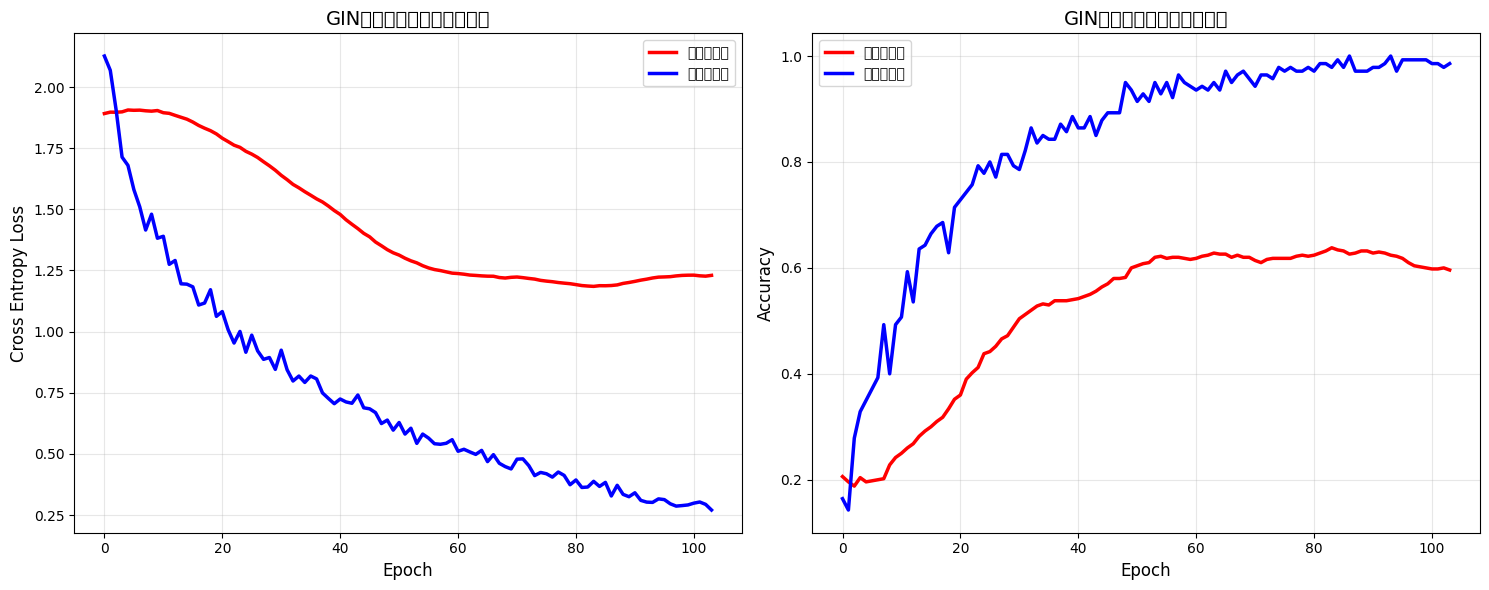


学習結果サマリー:
最終訓練精度: 0.986
最終検証精度: 0.596
最終テスト精度: 0.488
学習エポック数: 104

MLP BatchNorm統計:
第1層MLP BatchNorm:
  running_mean[:5]: tensor([-0.0314, -0.0289, -0.0412,  0.0147, -0.0323])
  running_var[:5]: tensor([0.0046, 0.0038, 0.0043, 0.0047, 0.0044])
第2層MLP BatchNorm:
  running_mean[:5]: tensor([-0.0536,  1.0471, -0.6111, -0.3735,  0.5567])
  running_var[:5]: tensor([2.5603, 2.7380, 2.1227, 2.2819, 2.4692])


In [22]:
f, axs = plt.subplots(1, 2, figsize=(15, 6))

# 損失の可視化
axs[0].plot(validation_loss, linewidth=2.5, color="red", label="検証データ")
axs[0].plot(training_loss, linewidth=2.5, color="blue", label="訓練データ")
axs[0].set_title("GIN学習における損失の推移", fontsize=14)
axs[0].set_ylabel("Cross Entropy Loss", fontsize=12)
axs[0].set_xlabel("Epoch", fontsize=12)
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# 精度の可視化
axs[1].plot(validation_acc, linewidth=2.5, color="red", label="検証データ")
axs[1].plot(training_acc, linewidth=2.5, color="blue", label="訓練データ")
axs[1].set_title("GIN学習における精度の推移", fontsize=14)
axs[1].set_ylabel("Accuracy", fontsize=12)
axs[1].set_xlabel("Epoch", fontsize=12)
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 学習結果のサマリー
print(f"\n学習結果サマリー:")
print(f"最終訓練精度: {training_acc[-1]:.3f}")
print(f"最終検証精度: {validation_acc[-1]:.3f}")
print(f"最終テスト精度: {test_acc:.3f}")
print(f"学習エポック数: {len(training_acc)}")

# MLPのBatchNorm統計確認
def print_batchnorm_stats(model):
    """各MLPのBatchNorm統計を表示"""
    if hasattr(model, 'conv1') and hasattr(model.conv1, 'nn'):
        # 第1層MLPのBatchNorm
        for i, layer in enumerate(model.conv1.nn):
            if isinstance(layer, nn.BatchNorm1d):
                print(f"第1層MLP BatchNorm:")
                print(f"  running_mean[:5]: {layer.running_mean[:5]}")
                print(f"  running_var[:5]: {layer.running_var[:5]}")
                break

        # 第2層MLPのBatchNorm
        for i, layer in enumerate(model.conv2.nn):
            if isinstance(layer, nn.BatchNorm1d):
                print(f"第2層MLP BatchNorm:")
                print(f"  running_mean[:5]: {layer.running_mean[:5]}")
                print(f"  running_var[:5]: {layer.running_var[:5]}")
                break

print(f"\nMLP BatchNorm統計:")
print_batchnorm_stats(model)

学習後のGIN特徴表現がラベルごとにクラスタリングできているか確認してみましょう。
t-SNEを用いてMLP変換後の特徴量を2次元に可視化し、GAT・GCNとの違いを観察します。

GIN特徴表現のt-SNE可視化を実行中...


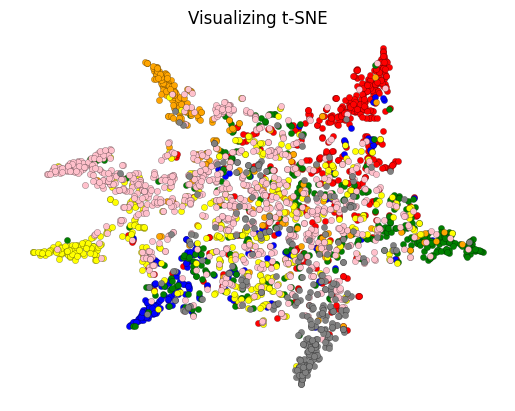


中間層（第1層GIN-MLP出力）の特徴表現も可視化してみましょう:
中間層特徴量のt-SNE可視化 (第1層MLP出力: 64次元→2次元)


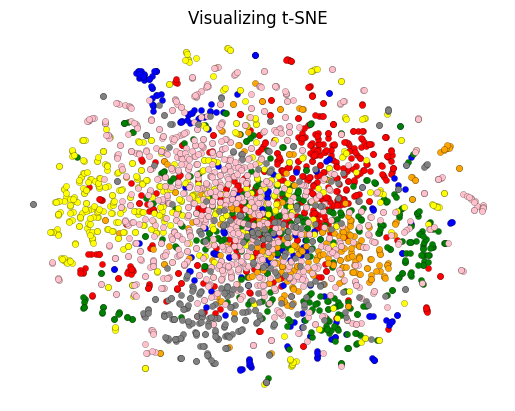


第1層MLP内部の特徴変化も確認してみましょう:


OSError: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev

In [24]:
# GIN特徴表現の可視化
print("GIN特徴表現のt-SNE可視化を実行中...")
visualize_embedding_tSNE(labels, y_pred, num_classes)

# 追加: 中間層（第1層GIN出力）の特徴量も可視化
print("\n中間層（第1層GIN-MLP出力）の特徴表現も可視化してみましょう:")
with torch.no_grad():
    model.eval()
    # 第1層GINConv（MLP1）の出力を取得
    x = model.conv1(features, edge_index)

    # 中間特徴量の可視化
    print("中間層特徴量のt-SNE可視化 (第1層MLP出力: 64次元→2次元)")
    visualize_embedding_tSNE(labels, x, num_classes)

# MLPの各段階での特徴変化を可視化
print("\n第1層MLP内部の特徴変化も確認してみましょう:")
# with torch.no_grad():
#     model.eval()

#     # GINの集約処理（近傍ノードの特徴量を集約）
#     from torch_geometric.utils import add_self_loops
#     from torch_scatter import scatter_add

#     # エッジインデックスに自己ループを追加
#     edge_index_with_loops, _ = add_self_loops(edge_index, num_nodes=features.size(0))

#     # 近傍集約（単純和）
#     row, col = edge_index_with_loops
#     deg = scatter_add(torch.ones_like(row, dtype=torch.float), row, dim=0, dim_size=features.size(0))

#     # 第1層MLPの最初の線形変換後
#     x_aggregated = scatter_add(features[col], row, dim=0, dim_size=features.size(0))
#     x_first_linear = model.conv1.nn[0](x_aggregated)  # 最初のLinear層

#     print("第1層MLP - 最初のLinear層出力の可視化:")
#     print("第1層MLP - Linear(1433→64)出力")
#     visualize_embedding_tSNE(labels, x_first_linear, num_classes)

In [25]:
print("="*60)
print("GIN実装の結果サマリー")
print("="*60)

print(f"\n【モデル仕様】")
print(f"  アーキテクチャ: 2層GIN + MLP [Linear→ReLU→Linear→BatchNorm]")
print(f"  入力次元: {features.shape[1]}")
print(f"  中間次元: {hidden_dim}")
print(f"  出力次元: {num_classes}")
print(f"  Dropout率: {dropout}")
print(f"  理論的表現力: WL-test同等")
print(f"  総パラメータ数: {count_parameters(model):,}")

# MLPパラメータの詳細
if hasattr(model, 'get_mlp_info'):
    mlp_info = model.get_mlp_info()
    print(f"    - MLP1パラメータ: {mlp_info['mlp1_parameters']:,}")
    print(f"    - MLP2パラメータ: {mlp_info['mlp2_parameters']:,}")

print(f"\n【学習設定】")
print(f"  最適化器: Adam (lr=0.0001, weight_decay=0.0001)")
print(f"  Early Stopping: 有効 (patience=20)")
print(f"  学習エポック数: {len(training_acc)}")
print(f"  学習時間: {t_end-t_start:.2f}秒")

print(f"\n【性能結果】")
print(f"  最終テスト精度: {test_acc:.3f}")
print(f"  最終検証精度: {validation_acc[-1]:.3f}")
print(f"  最終訓練精度: {training_acc[-1]:.3f}")

print(f"\n【3手法の特徴比較】")
print(f"  GAT: Multi-head Attention機構による適応的重み付け")
print(f"  GCN: 正規化された近傍集約による効率的学習")
print(f"  GIN: MLP変換による最強の理論的表現力")

print(f"\n【GINの優位性】")
print(f"  ✓ 理論的に最強の表現力（WL-test同等）")
print(f"  ✓ MLPによる複雑な非線形変換")
print(f"  ✓ 中央ノード特徴量の明示的保持")
print(f"  ✓ BatchNormによる学習安定化")

print(f"\n【計算複雑度とのトレードオフ】")
print(f"  パラメータ数順: GAT ≈ GIN > GCN")
print(f"  計算時間順: GIN > GAT > GCN")
print(f"  理論的表現力: GIN > GAT ≈ GCN")

print("="*60)


GIN実装の結果サマリー

【モデル仕様】
  アーキテクチャ: 2層GIN + MLP [Linear→ReLU→Linear→BatchNorm]
  入力次元: 1433
  中間次元: 64
  出力次元: 7
  Dropout率: 0.5
  理論的表現力: WL-test同等
  総パラメータ数: 100,693
    - MLP1パラメータ: 96,064
    - MLP2パラメータ: 4,629

【学習設定】
  最適化器: Adam (lr=0.0001, weight_decay=0.0001)
  Early Stopping: 有効 (patience=20)
  学習エポック数: 104
  学習時間: 25.50秒

【性能結果】
  最終テスト精度: 0.488
  最終検証精度: 0.596
  最終訓練精度: 0.986

【3手法の特徴比較】
  GAT: Multi-head Attention機構による適応的重み付け
  GCN: 正規化された近傍集約による効率的学習
  GIN: MLP変換による最強の理論的表現力

【GINの優位性】
  ✓ 理論的に最強の表現力（WL-test同等）
  ✓ MLPによる複雑な非線形変換
  ✓ 中央ノード特徴量の明示的保持
  ✓ BatchNormによる学習安定化

【計算複雑度とのトレードオフ】
  パラメータ数順: GAT ≈ GIN > GCN
  計算時間順: GIN > GAT > GCN
  理論的表現力: GIN > GAT ≈ GCN
